In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import utils
from itertools import product
from fair_self_training import biased_vs_fair_test_error

### Self-training with LDA

In [2]:
mu = 3.
prop = 0.1
# Labeled biased data
biased_train_x, biased_train_y = utils.sim_x_y(prop, n = 60, mu = mu)

# Unlableled fair data and test data
fair_train_x, fair_train_y = utils.sim_x_y(0.5, n = 2000, mu=mu)
fair_test_x,  fair_test_y = utils.sim_x_y(0.5, n = 2000, mu=mu)

In [3]:
cl_unfair = LogisticRegression(max_iter=1000)
cl_unfair.fit(biased_train_x, biased_train_y)
error_fair = np.mean(np.absolute(fair_test_y - cl_unfair.predict(fair_test_x)))
error_fair

0.0305

In [4]:
coef, intercept = cl_unfair.coef_.reshape((-1,)), cl_unfair.intercept_.reshape(())
u = biased_train_x[:, 0]
v = -( intercept + coef[0] * u )/coef[1]
print(f'Self-trained model: coef {coef}, intercept {intercept}\n')

Self-trained model: coef [1.18381163 1.61855916], intercept -5.339675905728304



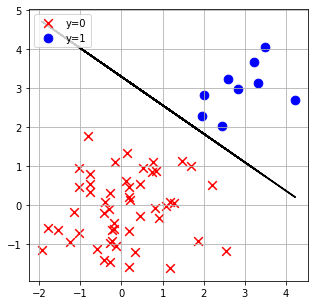

In [5]:
ax = utils.plot_x_y(biased_train_x, biased_train_y, line = [u, v])

In [6]:
cl_self_trained = cl_unfair
for i in range(100):
    pseudo_fair_train_y = cl_self_trained.predict(fair_train_x)
    augmented_x = np.concatenate([biased_train_x, fair_train_x], axis = 0)
    augmented_y = np.concatenate([biased_train_y, pseudo_fair_train_y], axis = 0)
    cl_self_trained.fit(augmented_x, augmented_y)
coef, intercept = cl_self_trained.coef_.reshape((-1, )), cl_self_trained.intercept_.reshape(())
print(f'Self-trained model: coef {coef}, intercept {intercept}\n')    
error_fair = np.mean(np.absolute(fair_test_y - cl_self_trained.predict(fair_test_x)))
error_fair

Self-trained model: coef [3.66818814 5.38278089], intercept -17.353781577075914



0.0325

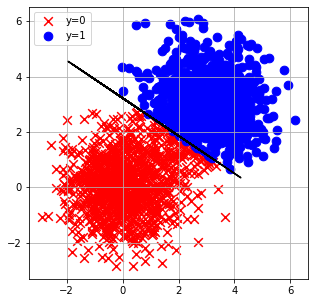

In [7]:
coef, intercept = cl_self_trained.coef_.reshape((-1,)), cl_self_trained.intercept_
u = biased_train_x[:, 0]
v = -( intercept[0] + coef[0] * u )/coef[1]
utils.plot_x_y(augmented_x, augmented_y, line=[u, v])

In [8]:
prop = [0.1, 0.2, 0.4]
mus = [2, 2.5, 3]
parameters = product(prop, mus, range(20))
dicts = []
for j, (p, mu, i) in enumerate(parameters,1):
    dict_error = biased_vs_fair_test_error(p, mu)
    dict_error['p'] = p
    dict_error['mu'] = mu
    dict_error['iter'] = i
    dicts.append(dict_error)
    if j%50 == 0:
        print(f'Done {j}\n')

Done 50

Done 100

Done 150



In [9]:
import pandas as pd
d = pd.DataFrame(dicts)

In [11]:
vars = ['baseline-error', 'self-trained-error']
agg_dict = dict()
for v in vars:
    agg_dict[v] = ['mean', 'std']
d.groupby(['p', 'mu']).agg(agg_dict)

baseline-error           self-trained-error          
                  mean       std               mean       std
p   mu                                                       
0.1 2.0       0.187925  0.079021           0.180375  0.092177
    2.5       0.087325  0.022735           0.067550  0.026141
    3.0       0.066175  0.030141           0.044550  0.034651
0.2 2.0       0.127325  0.038726           0.119325  0.035426
    2.5       0.068850  0.027158           0.056750  0.023042
    3.0       0.030275  0.014824           0.020600  0.007135
0.4 2.0       0.084400  0.008765           0.084550  0.010035
    2.5       0.041775  0.007410           0.041550  0.005712
    3.0       0.021125  0.002738           0.018700  0.002677

In [12]:
np.arange(0.1, 0.4, 0.05)

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])

In [16]:
p = np.arange(0.1, 0.4, 0.05)
mus = [2, 2.5, 3, 3.5, 4, 4.5, 5]
parameters = list(product(p,mus, range(500)))

In [17]:
len(parameters)/50

490.0